In [2]:
%reset
import os
import urllib.request
import tarfile
# Crea una cartella per i dati
os.makedirs("cora_original", exist_ok=True)

# Scarica e decomprimi
url = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"
urllib.request.urlretrieve(url, "cora.tgz")

with tarfile.open("cora.tgz", "r:gz") as tar:
    tar.extractall("cora_original")

Nothing done.


D:\Temp\ipykernel_4712\612172139.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("cora_original")


In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
import seaborn as sns
import scipy.sparse as sp
# Carica i nodi (paper + feature + classi)
nodes = pd.read_csv(
    "cora_original/cora/cora.content",
    sep = "\t",
    header = None,
    names = ["paper_id"] + [f"word_{i}" for i in range(1433)]+["class"]
)

# Carica gli archi (citazioni dirette)
edges = pd.read_csv(
    "cora_original/cora/cora.cites",
    sep = "\t",
    header = None,
    names = ["cited_paper", "citing_paper"]
)

# Crea il grafo diretto dagli archi (senza attributi)
G_directed = nx.from_pandas_edgelist( edges,source="citing_paper", target="cited_paper", create_using=nx.DiGraph)

# Aggiungi attributi ai nodi dal DataFrame `nodes`
for _, row in nodes.iterrows():
    node_id = row["paper_id"]
    G_directed.nodes[node_id]["features"] = row[1:-1].values.astype(int) # Features
    G_directed.nodes[node_id]["class"] = row["class"] #class
    
# Creazione di un dizionario ID originale → indice numerico
node_to_index = {node: idx for idx, node in enumerate(G_directed.nodes())}
# Aggiungi l'indice come attributo a ogni nodo
for node, idx in node_to_index.items():
    G_directed.nodes[node]["index"] = idx

# Crea una copia non diretta
G_undirected = G_directed.to_undirected()


In [4]:
print(f"Nodi: {G_directed.number_of_nodes()}")
print(f"Archi diretti: {G_directed.number_of_edges()}")
density = nx.density(G_directed)
print(f"Densità: {density:.6f}")
n = G_directed.number_of_nodes()
m = G_directed.number_of_edges()
in_degrees = dict(G_directed.in_degree())
out_degrees = dict(G_directed.out_degree())


avg_in_degree = sum(in_degrees.values()) / n
avg_out_degree = sum(out_degrees.values()) / n

print(f"Grado medio in entrata: {avg_in_degree:.2f}")  
print(f"Grado medio in uscita: {avg_out_degree:.2f}")   

Nodi: 2708
Archi diretti: 5429
Densità: 0.000741
Grado medio in entrata: 2.00
Grado medio in uscita: 2.00


In [5]:
print(f"Density undirected {nx.density(G_undirected)}" )
n_unid = G_undirected.number_of_nodes()
m_unid = G_undirected.number_of_edges()
in_degrees_unid = dict(G_undirected.degree())

print(n_unid)
print(m_unid)

avg_in_degree_unid = sum(in_degrees_unid.values()) / n_unid

print(f"Grado medio in entrata: {avg_in_degree_unid:.2f}")  


Density undirected 0.0014399999126942077
2708
5278
Grado medio in entrata: 3.90


In [6]:
# Verifica se il grafo indiretto è connesso
is_connected = nx.is_connected(G_undirected)
print(f"Grafo connesso? {is_connected}")

num_components = nx.number_connected_components(G_undirected)
print(f"Numero di componenti connesse: {num_components}")

# Dimensioni delle componenti connesse
component_sizes = [len(c) for c in nx.connected_components(G_undirected)]
print(np.mean(component_sizes))
print(f"Dimensioni delle componenti: {sorted(component_sizes, reverse=True)}")
print(f"Numero di nodi nella componente piu' grande {np.max(component_sizes)}")
print(f"Percentuale di nodi appartenti alla giant component {np.max(component_sizes)/n*100}")
# Count frequency of each component size
size_counts = Counter(component_sizes)

# Convert to sorted list for display
sorted_counts = sorted(size_counts.items(), key=lambda x: x[0])

# Print results
print("\nConteggio delle dimensioni delle componenti:")
print("Dimensione | Conteggio")
print("----------------------")
for size, count in sorted_counts:
    print(f"{size:9d} | {count:8d}")

# Optional: Print as percentage
total_components = len(component_sizes)
print("\nPercentuale delle dimensioni delle componenti:")
print("Dimensione | Percentuale")
print("----------------------")
for size, count in sorted_counts:
    percentage = (count / total_components) * 100
    print(f"{size:9d} | {percentage:8.2f}%")


Grafo connesso? False
Numero di componenti connesse: 78
34.717948717948715
Dimensioni delle componenti: [2485, 26, 9, 8, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Numero di nodi nella componente piu' grande 2485
Percentuale di nodi appartenti alla giant component 91.76514032496307

Conteggio delle dimensioni delle componenti:
Dimensione | Conteggio
----------------------
        2 |       57
        3 |        7
        4 |        6
        5 |        3
        6 |        1
        8 |        1
        9 |        1
       26 |        1
     2485 |        1

Percentuale delle dimensioni delle componenti:
Dimensione | Percentuale
----------------------
        2 |    73.08%
        3 |     8.97%
        4 |     7.69%
        5 |     3.85%
        6 |     1.28%
        8 |     1.28%
        9 |     1.28%
       

Number of SCCs: 2526
Largest SCC size: 13
SCC sizes: [13, 7, 6, 5, 5, 5, 5, 4, 4, 4]...
Average SCC sizes: 1.0720506730007917


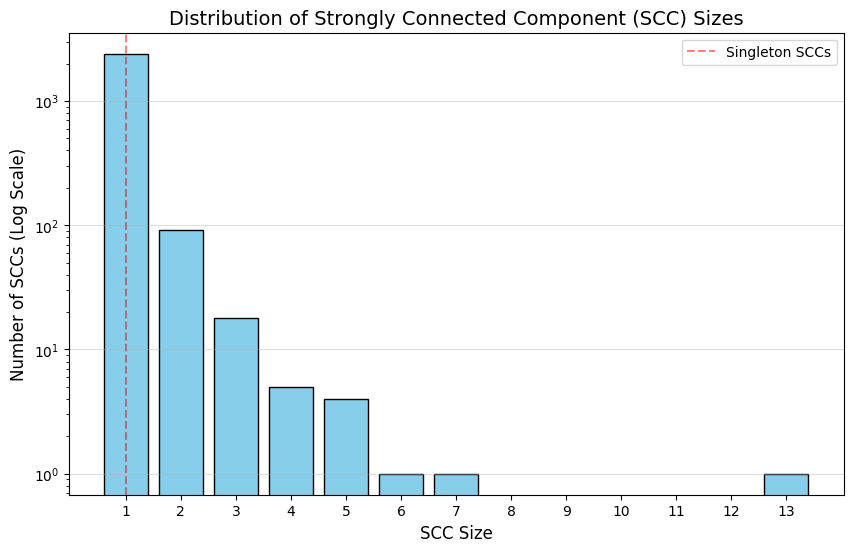

In [7]:
from collections import Counter

#Strongly Connected Components
sccs = list(nx.strongly_connected_components(G_directed))
scc_sizes = sorted([len(scc) for scc in sccs], reverse=True)
print(f"Number of SCCs: {len(sccs)}")
print(f"Largest SCC size: {scc_sizes[0]}")
print(f"SCC sizes: {scc_sizes[:10]}...")
print(f"Average SCC sizes: {np.sum(scc_sizes)/len(sccs)}")

# Count frequency of each SCC size
size_counts = Counter(scc_sizes)
sizes = sorted(size_counts.keys())
counts = [size_counts[size] for size in sizes]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(sizes, counts, color='skyblue', edgecolor='black')



plt.axvline(x=1, color='red', linestyle='--', alpha=0.5, label="Singleton SCCs")

# Formatting
plt.xlabel("SCC Size", fontsize=12)
plt.ylabel("Number of SCCs (Log Scale)", fontsize=12)
plt.title("Distribution of Strongly Connected Component (SCC) Sizes", fontsize=14)
plt.yscale('log')  # Use log scale for better visibility
plt.xticks(range(1, max(sizes)+1))
plt.grid(axis='y', alpha=0.4)
plt.legend()
plt.show()


In [8]:
reciprocity = nx.reciprocity(G_directed)
print(f"Reciprocity: {reciprocity:.4f}")

Reciprocity: 0.0556


In [9]:
# Find all weakly connected components (WCCs) in the directed graph
wccs = list(nx.weakly_connected_components(G_directed))

# Identify the largest WCC (should match the undirected giant component of 2,485 nodes)
largest_wcc = max(wccs, key=len)
print(f"Largest WCC size: {len(largest_wcc)} nodes")

# Create a subgraph of the directed graph containing only the largest WCC
G_dir_lwc = G_directed.subgraph(largest_wcc).copy()

# Create an undirected version of this subgraph
G_undir_lwc = G_dir_lwc.to_undirected()

# Check connectivity
print("Directed subgraph is weakly connected:", nx.is_weakly_connected(G_dir_lwc))  # True
print("Undirected subgraph is connected:", nx.is_connected(G_undir_lwc))    


print("\nUndirected Subgraph:")
print(f"Nodes: {G_undir_lwc.number_of_nodes()}")
print(f"Edges: {G_undir_lwc.number_of_edges()}")
print(f"Density: {nx.density(G_undir_lwc):.6f}")
print(f"Average clustering: {nx.average_clustering(G_undir_lwc):.4f}")

print("\nDirected Subgraph:")
print(f"Nodes: {G_dir_lwc.number_of_nodes()}")
print(f"Edges: {G_dir_lwc.number_of_edges()}")
print(f"Density: {nx.density(G_dir_lwc):.6f}")
print(f"Reciprocity: {nx.reciprocity(G_dir_lwc):.4f}")
print(f"Strongly Connected Components: {nx.number_strongly_connected_components(G_dir_lwc)}")

Largest WCC size: 2485 nodes
Directed subgraph is weakly connected: True
Undirected subgraph is connected: True

Undirected Subgraph:
Nodes: 2485
Edges: 5069
Density: 0.001642
Average clustering: 0.2376

Directed Subgraph:
Nodes: 2485
Edges: 5209
Density: 0.000844
Reciprocity: 0.0538
Strongly Connected Components: 2315


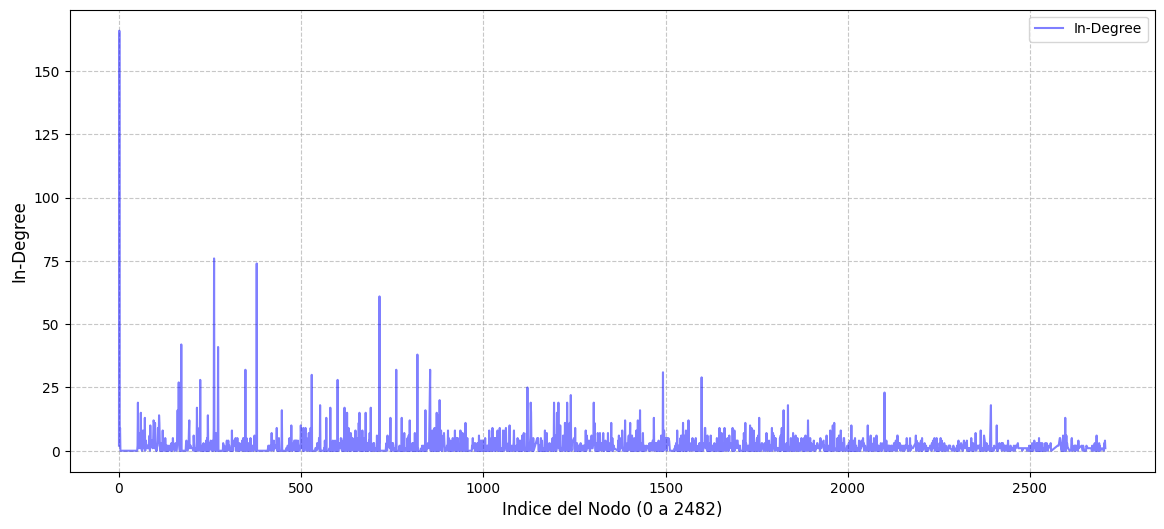

In [10]:
# Calcola in-degree e out-degree
in_degrees = [d for _, d in G_dir_lwc.in_degree()]
out_degrees = [d for _, d in G_dir_lwc.out_degree()]
# Ordina i nodi per indice numerico (0, 1, 2, ...)
sorted_nodes = sorted(G_dir_lwc.nodes(), key=lambda x: G_dir_lwc.nodes[x]["index"])
sorted_indices = [G_dir_lwc.nodes[node]["index"] for node in sorted_nodes]

# Crea il plot
plt.figure(figsize=(14, 6))

# In-degree (blu)
plt.plot(
    sorted_indices,
    [G_dir_lwc.in_degree(node) for node in sorted_nodes],
    alpha=0.5,
    color='blue',
    label='In-Degree'
)

plt.xlabel('Indice del Nodo (0 a 2482)', fontsize=12)
plt.ylabel('In-Degree', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

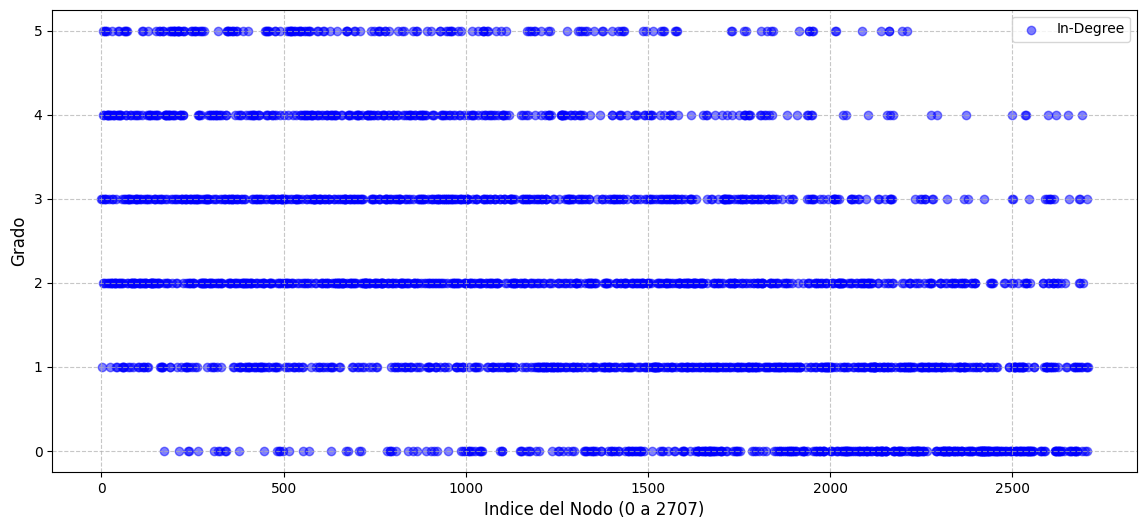

In [11]:
plt.figure(figsize=(14, 6))

# In-degree (blu)
plt.scatter(
    sorted_indices,
    [G_dir_lwc.out_degree(node) for node in sorted_nodes],
    alpha=0.5,
    color='blue',
    label='In-Degree'
)

plt.xlabel('Indice del Nodo (0 a 2707)', fontsize=12)
plt.ylabel('Grado', fontsize=12)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

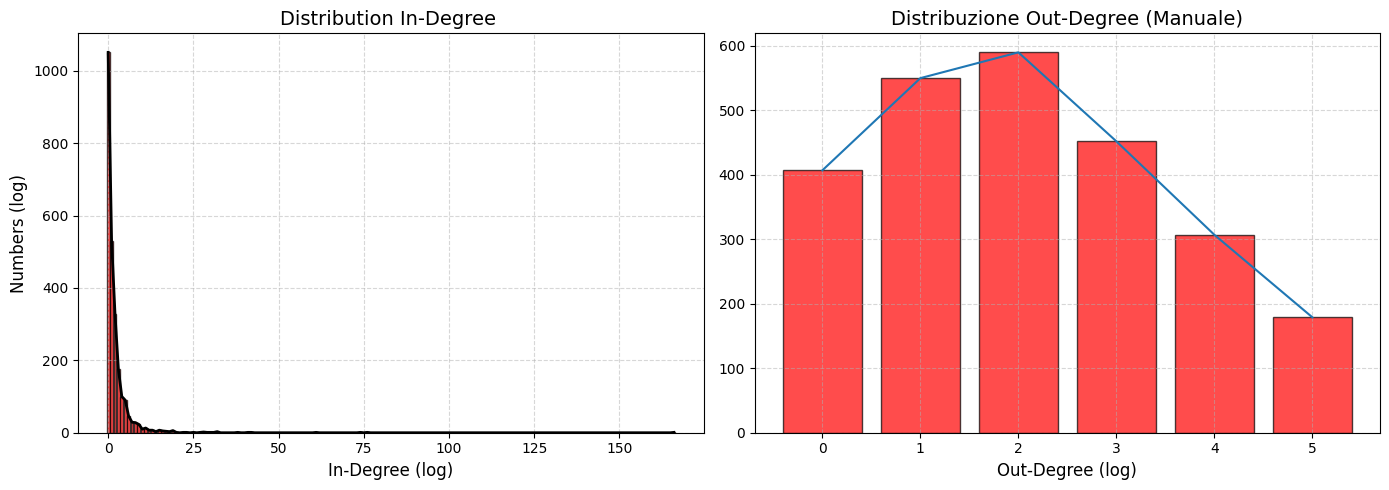

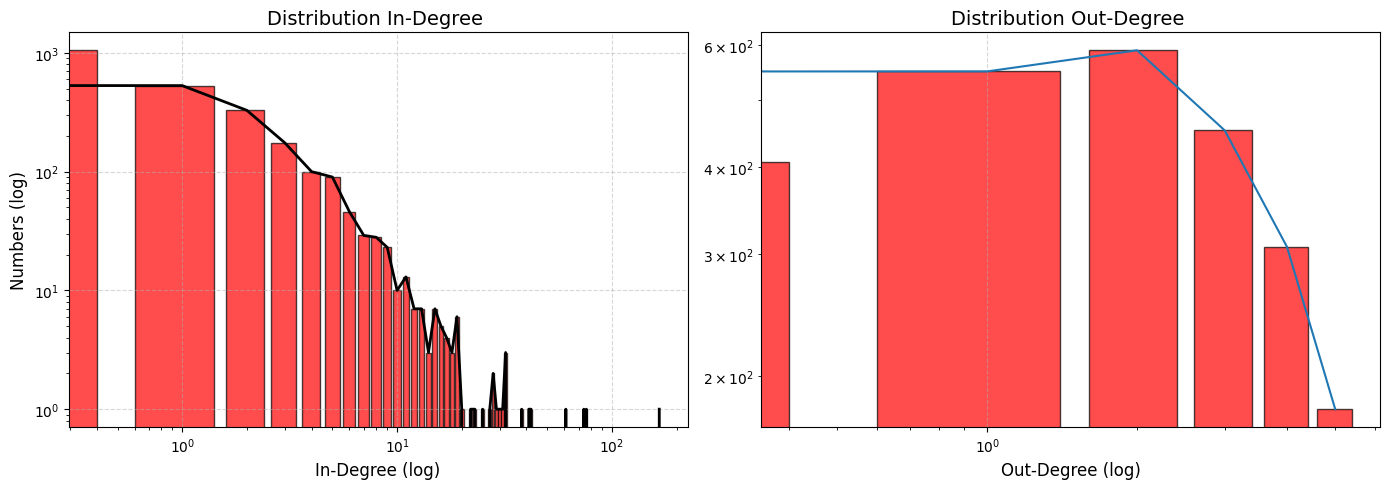

In [12]:
# Calcola in-degree e out-degree
in_degrees = [d for _, d in G_dir_lwc.in_degree()]
out_degrees = [d for _, d in G_dir_lwc.out_degree()]
# Istogramma manuale per in-degree
max_in = np.max(in_degrees)
hist_in = np.zeros(max_in + 1, dtype=int)
for d in in_degrees:
    hist_in[d] += 1

# Istogramma manuale per out-degree
max_out = np.max(out_degrees)
hist_out = np.zeros(max_out + 1, dtype=int)
for d in out_degrees:
    hist_out[d] += 1

# Plot
plt.figure(figsize=(14, 5))

# In-Degree
plt.subplot(1, 2, 1)
plt.bar(range(len(hist_in)), hist_in, color='red', alpha=0.7, edgecolor='black')
plt.plot(hist_in,color='black', linewidth=2)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('In-Degree (log)', fontsize=12)
plt.ylabel('Numbers (log)', fontsize=12)
plt.title('Distribution In-Degree ', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Out-Degree
plt.subplot(1, 2, 2)
plt.bar(range(len(hist_out)), hist_out, color='red', alpha=0.7, edgecolor='black')
plt.plot(hist_out)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Out-Degree (log)', fontsize=12)
plt.title('Distribuzione Out-Degree (Manuale)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

# In-Degree
plt.subplot(1, 2, 1)
plt.bar(range(len(hist_in)), hist_in, color='red', alpha=0.7, edgecolor='black')
plt.plot(hist_in,color='black', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('In-Degree (log)', fontsize=12)
plt.ylabel('Numbers (log)', fontsize=12)
plt.title('Distribution In-Degree ', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Out-Degree
plt.subplot(1, 2, 2)
plt.bar(range(len(hist_out)), hist_out, color='red', alpha=0.7, edgecolor='black')
plt.plot(hist_out)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Out-Degree (log)', fontsize=12)
plt.title('Distribution Out-Degree ', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Log‑normal μ = -9.0995,  σ = 2.6341
Power‑law α = 2.6756,  xmin = 5.0


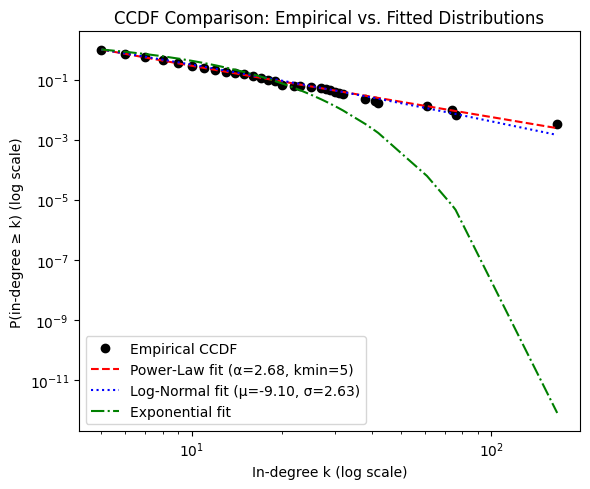

Power-Law vs Log-Normale: R=-0.30, p=0.6510
Power-Law vs Esponenziale: R=54.07, p=0.0143


In [13]:
import powerlaw
# (1) FIT A POWER‐LAW TO THE IN‐DEGREES (DISCRETE FITTING)

# Create a Fit object; by default, it will treat the data as discrete
fit = powerlaw.Fit(in_degrees, discrete=True)
# Extract estimated parameters
alpha_est = fit.power_law.alpha       # Estimated exponent α
xmin_est  = fit.power_law.xmin        # Estimated cut‐off x_min

# 2) Extract log-normal parameters
mu_ln    = fit.lognormal.mu
sigma_ln = fit.lognormal.sigma

print(f"Log‑normal μ = {mu_ln:.4f},  σ = {sigma_ln:.4f}")
print(f"Power‑law α = {alpha_est:.4f},  xmin = {xmin_est}")

# Step 1: Make a single figure & axis
fig, ax = plt.subplots(figsize=(6, 5))

# Step 2: Plot the empirical CCDF on that axis
#    (This will plot all points P(k' ≥ k) for k ≥ 1, but only draw markers where counts > 0.)
fit.plot_ccdf(ax=ax, 
              label="Empirical CCDF", 
              color="black", 
              marker="o", 
              linestyle="None",
              # By default, fit.plot_ccdf() plots over the range [min(data), max(data)].
              )

# Step 3: Overlay the power‐law fit (tail) on the same axis
#    This plots the theoretical CCDF curve for k ≥ xmin. 
#    It automatically uses the same fit.power_law.alpha and fit.power_law.xmin.
fit.power_law.plot_ccdf(ax=ax, 
                       label=f"Power‐Law fit (α={alpha_est:.2f}, "
                             f"kmin={int(xmin_est)})",
                       color="red", 
                       linestyle="--",
                       )

# Step 4: Overlay the log‐normal fit (tail) on that same axis
#    Again, it uses fit.lognormal.mu and fit.lognormal.sigma internally.
fit.lognormal.plot_ccdf(ax=ax, 
                       label=f"Log‐Normal fit (μ={fit.lognormal.mu:.2f}, "
                             f"σ={fit.lognormal.sigma:.2f})",
                       color="blue", 
                       linestyle=":",
                       )

# Step 5: Overlay the exponential fit (tail) on that same axis
fit.exponential.plot_ccdf(ax=ax, 
                         label="Exponential fit", 
                         color="green", 
                         linestyle="-.",
                         )

# Step 6: Tidy up labels, legend, and scales
ax.set_xlabel("In‐degree k (log scale)")
ax.set_ylabel("P(in‐degree ≥ k) (log scale)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("CCDF Comparison: Empirical vs. Fitted Distributions")
ax.legend()
plt.tight_layout()

# Finally, show everything in one single plot
plt.show()
R_pl_ln, p_pl_ln = fit.distribution_compare('power_law', 'lognormal')
R_pl_exp, p_pl_exp = fit.distribution_compare('power_law', 'exponential')
print(f"Power-Law vs Log-Normale: R={R_pl_ln:.2f}, p={p_pl_ln:.4f}")
print(f"Power-Law vs Esponenziale: R={R_pl_exp:.2f}, p={p_pl_exp:.4f}")

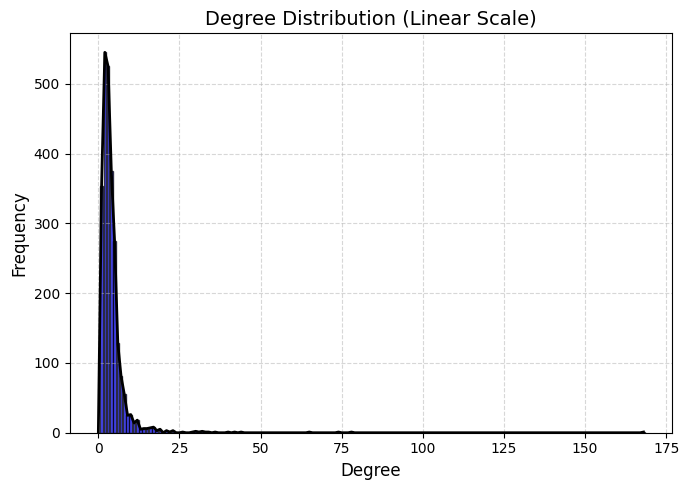

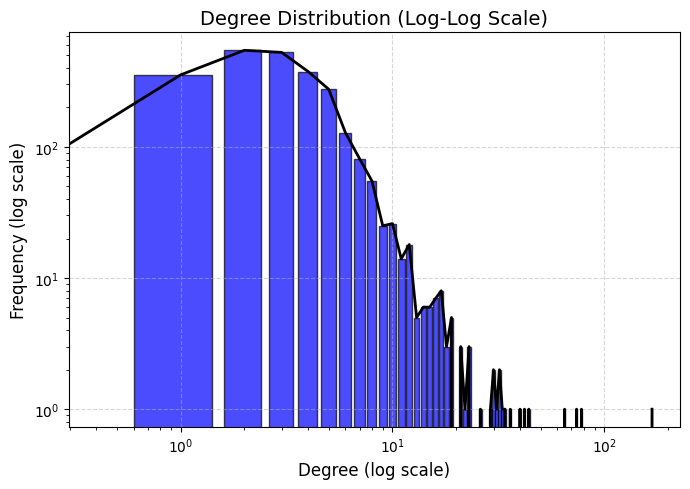

In [14]:
# Calculate degrees for undirected graph
degrees = [d for _, d in G_undir_lwc.degree()]
max_deg = np.max(degrees)
hist_deg = np.zeros(max_deg + 1, dtype=int)
for d in degrees:
    hist_deg[d] += 1

# Plot linear scale
plt.figure(figsize=(7, 5))
plt.bar(range(len(hist_deg)), hist_deg, color='blue', alpha=0.7, edgecolor='black')
plt.plot(hist_deg, color='black', linewidth=2)
plt.xlabel('Degree', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Degree Distribution (Linear Scale)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot log-log scale
plt.figure(figsize=(7, 5))
plt.bar(range(len(hist_deg)), hist_deg, color='blue', alpha=0.7, edgecolor='black')
plt.plot(hist_deg, color='black', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log scale)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.title('Degree Distribution (Log-Log Scale)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
Log-normal μ = -39.8273, σ = 4.6439
Power-law α = 2.9843, xmin = 9.0


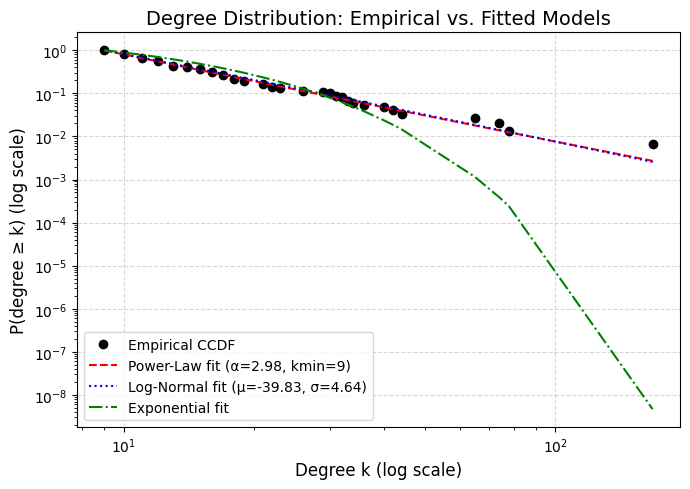

Power-Law vs Log-Normal: R = -0.0083, p = 0.9484
Power-Law vs Exponential: R = 23.4883, p = 0.0548


In [15]:
import powerlaw
import matplotlib.pyplot as plt
import numpy as np

# Calculate degrees for undirected graph
degrees = [d for _, d in G_undir_lwc.degree()]

# (1) FIT POWER-LAW TO DEGREES (DISCRETE FITTING)
fit = powerlaw.Fit(degrees, discrete=True)

# Extract parameters
alpha_est = fit.power_law.alpha        # Power-law exponent
xmin_est = fit.power_law.xmin          # Estimated cut-off x_min
mu_ln = fit.lognormal.mu               # Log-normal μ
sigma_ln = fit.lognormal.sigma         # Log-normal σ

print(f"Log-normal μ = {mu_ln:.4f}, σ = {sigma_ln:.4f}")
print(f"Power-law α = {alpha_est:.4f}, xmin = {xmin_est}")

# Create comparison plot
fig, ax = plt.subplots(figsize=(7, 5))

# Plot empirical CCDF (Complementary Cumulative Distribution Function)
fit.plot_ccdf(ax=ax, 
              label="Empirical CCDF", 
              color="black", 
              marker="o", 
              linestyle="None")

# Overlay power-law fit
fit.power_law.plot_ccdf(ax=ax, 
                       label=f"Power-Law fit (α={alpha_est:.2f}, "
                             f"kmin={int(xmin_est)})",
                       color="red", 
                       linestyle="--")

# Overlay log-normal fit
fit.lognormal.plot_ccdf(ax=ax, 
                       label=f"Log-Normal fit (μ={mu_ln:.2f}, "
                             f"σ={sigma_ln:.2f})",
                       color="blue", 
                       linestyle=":")

# Overlay exponential fit
fit.exponential.plot_ccdf(ax=ax, 
                         label="Exponential fit", 
                         color="green", 
                         linestyle="-.")

# Configure plot
ax.set_xlabel("Degree k (log scale)", fontsize=12)
ax.set_ylabel("P(degree ≥ k) (log scale)", fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Degree Distribution: Empirical vs. Fitted Models", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Statistical comparisons
R_pl_ln, p_pl_ln = fit.distribution_compare('power_law', 'lognormal')
R_pl_exp, p_pl_exp = fit.distribution_compare('power_law', 'exponential')

print(f"Power-Law vs Log-Normal: R = {R_pl_ln:.4f}, p = {p_pl_ln:.4f}")
print(f"Power-Law vs Exponential: R = {R_pl_exp:.4f}, p = {p_pl_exp:.4f}")

In [16]:
homophily = nx.attribute_assortativity_coefficient(G_undir_lwc, 'class')

print(f"Homophily (assortativity) coefficient: {homophily:.4f}")

Homophily (assortativity) coefficient: 0.7637


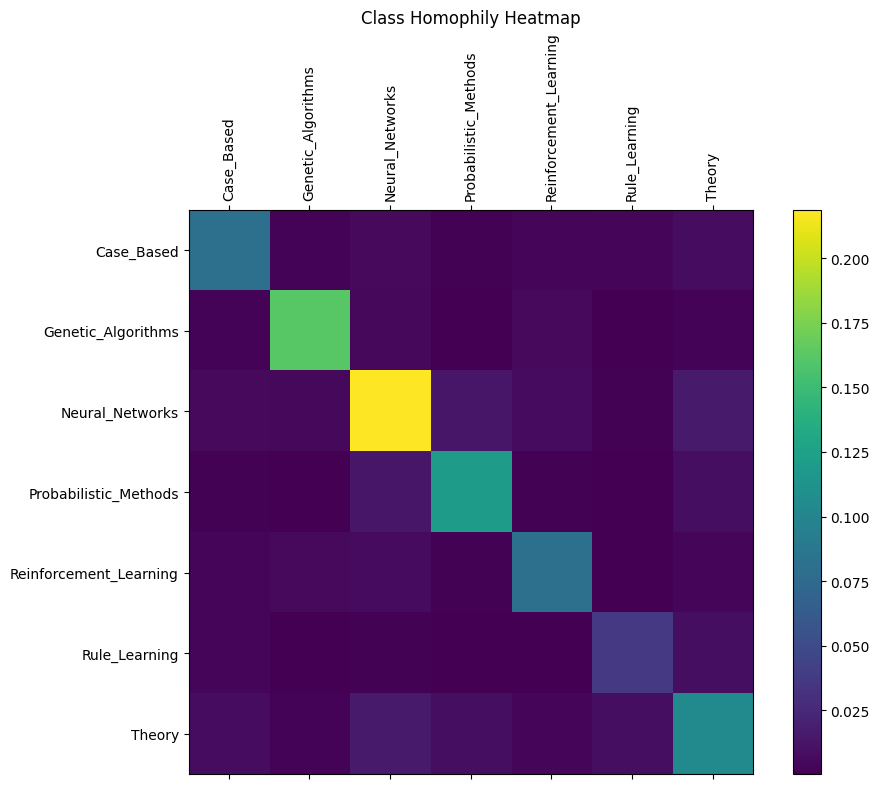

Class Homophily Matrix (Probability Distribution)
Rows: Source Class, Columns: Target Class

            Case_Bas     | Genetic_     | Neural_N     | Probabil     | Reinforc     | Rule_Lea     | Theory      
------------------------------------------------------------------------------------------------------------------
Case_Based   | 0.0809 | 0.0026 | 0.0053 | 0.0019 | 0.0028 | 0.0044 | 0.0074
Genetic_Algo | 0.0026 | 0.1622 | 0.0052 | 0.0002 | 0.0061 | 0.0002 | 0.0023
Neural_Netwo | 0.0053 | 0.0052 | 0.2188 | 0.0131 | 0.0066 | 0.0016 | 0.0159
Probabilisti | 0.0019 | 0.0002 | 0.0131 | 0.1205 | 0.0019 | 0.0006 | 0.0087
Reinforcemen | 0.0028 | 0.0061 | 0.0066 | 0.0019 | 0.0805 | 0.0002 | 0.0032
Rule_Learnin | 0.0044 | 0.0002 | 0.0016 | 0.0006 | 0.0002 | 0.0367 | 0.0079
Theory       | 0.0074 | 0.0023 | 0.0159 | 0.0087 | 0.0032 | 0.0079 | 0.1046

Key Observations:
- Values on diagonal (same-class connections) show strongest homophily
- Off-diagonal values show cross-class connection proba

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Get the unique class labels from the graph
class_labels = sorted(set(nx.get_node_attributes(G_undir_lwc, 'class').values()))

# Create the mixing matrix
mixing_matrix = nx.attribute_mixing_matrix(G_undir_lwc, 'class', mapping={k: i for i, k in enumerate(class_labels)})

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.matshow(mixing_matrix, fignum=0)
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=90)
plt.yticks(np.arange(len(class_labels)), class_labels)
plt.colorbar()
plt.title("Class Homophily Heatmap")
plt.tight_layout()
plt.show()
print("Class Homophily Matrix (Probability Distribution)")
print("="*60)
print("Rows: Source Class, Columns: Target Class\n")

# Print header with class names
header = " " * 12 + " | ".join(f"{label[:8]:<12}" for label in class_labels)
print(header)
print("-" * len(header))

# Print each row with class label and values
for i, label in enumerate(class_labels):
    row = f"{label[:12]:<12}" + " | "
    row += " | ".join(f"{val:.4f}" for val in mixing_matrix[i])
    print(row)

# Add interpretation notes
print("\nKey Observations:")
print("- Values on diagonal (same-class connections) show strongest homophily")
print("- Off-diagonal values show cross-class connection probabilities")
print("- Matrix is symmetric (undirected graph)")

In [18]:
# =================================================================
# 7. Global Path Metrics (Undirected)
# =================================================================
# Connected by definition in undirected space
undir_metrics = {
    "ASPL": nx.average_shortest_path_length(G_undir_lwc),
    "Diameter": nx.diameter(G_undir_lwc)
}

# Calculate effective diameter (90th percentile of path lengths)
all_paths_undir = []
for node in G_undir_lwc.nodes():
    paths = nx.single_source_shortest_path_length(G_undir_lwc, node)
    all_paths_undir.extend(d for d in paths.values() if d > 0)
undir_metrics["Effective_Diameter"] = np.percentile(all_paths_undir, 90)
"""
# Theoretical random graph ASPL
n = G_undir_lwc.number_of_nodes()
avg_degree = 2 * G_undir_lwc.number_of_edges() / n
undir_metrics["Theoretical_ASPL"] = np.log(n) / np.log(avg_degree)
"""
print("Undirected Path Metrics:")
print(undir_metrics)
# =================================================================
# 8. Directed Path Analysis
# =================================================================
dir_metrics = {}
reachable_pairs = 0
path_lengths_dir = []

# Compute directed paths and reachability
for source in G_dir_lwc.nodes():
    paths = nx.single_source_shortest_path_length(G_dir_lwc, source)
    for target, dist in paths.items():
        if source != target:
            path_lengths_dir.append(dist)
            reachable_pairs += 1

total_possible_pairs = n * (n - 1)
dir_metrics["Reachability_Ratio"] = reachable_pairs / total_possible_pairs

# ASPL for reachable pairs only
dir_metrics["ASPL_reachable"] = sum(path_lengths_dir) / reachable_pairs if reachable_pairs else 0
print("\nDirected Path Metrics:")
print(dir_metrics)
plt.show()

Undirected Path Metrics:
{'ASPL': 6.310998681298742, 'Diameter': 19, 'Effective_Diameter': np.float64(9.0)}

Directed Path Metrics:
{'Reachability_Ratio': 0.0064266612246056095, 'ASPL_reachable': 4.812464180340048}


# Centrality Measures


--- Top 10 degree centrality (undirected) ---
       node                   class  degree_cent
1        35      Genetic_Algorithms     0.067633
261    6213  Reinforcement_Learning     0.031401
374    1365         Neural_Networks     0.029791
711    3229         Neural_Networks     0.026167
272     910         Neural_Networks     0.017713
171     114  Reinforcement_Learning     0.016908
815    4330   Probabilistic_Methods     0.016103
757    3231                  Theory     0.014493
343    1272                  Theory     0.013688
1451  19621         Neural_Networks     0.013285

--- Top 10 closeness centrality (undirected) ---
        node                   class  closeness_cent
1         35      Genetic_Algorithms        0.242768
261     6213  Reinforcement_Learning        0.241048
711     3229         Neural_Networks        0.239560
164      887      Genetic_Algorithms        0.235406
848     4584  Reinforcement_Learning        0.235339
223     6214  Reinforcement_Learning        0.

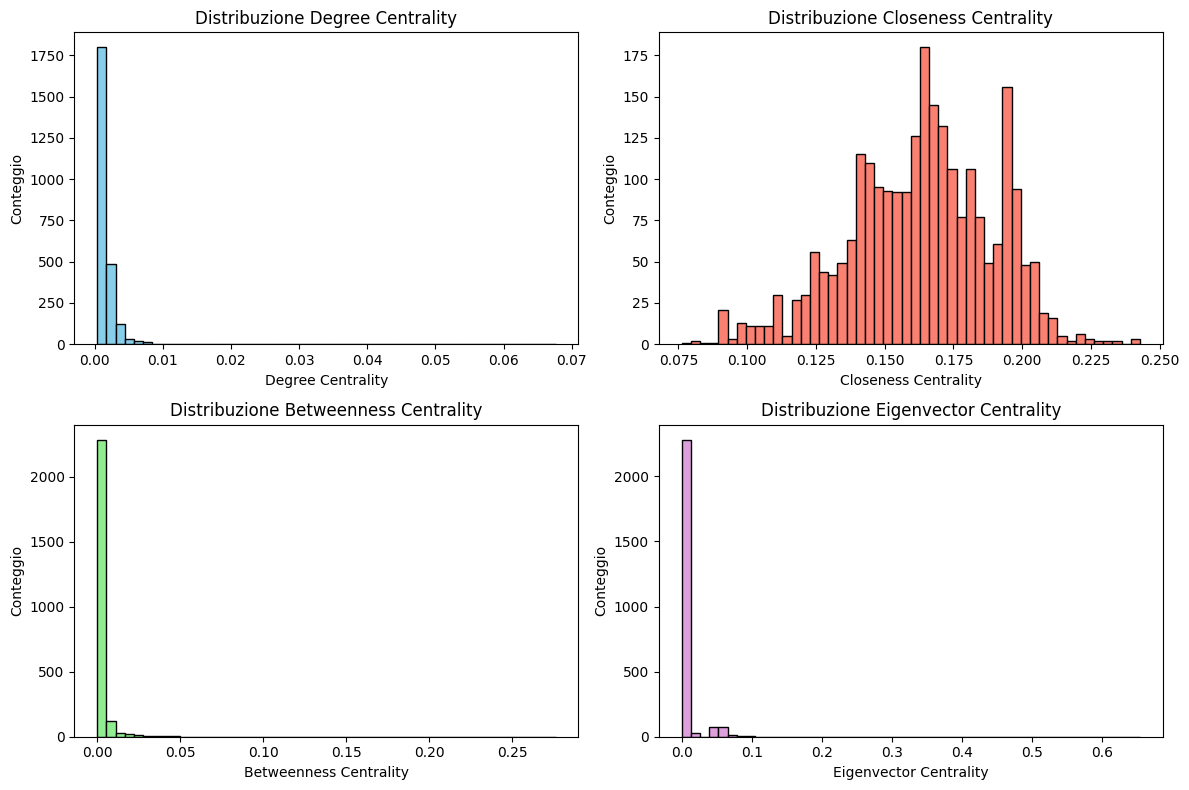

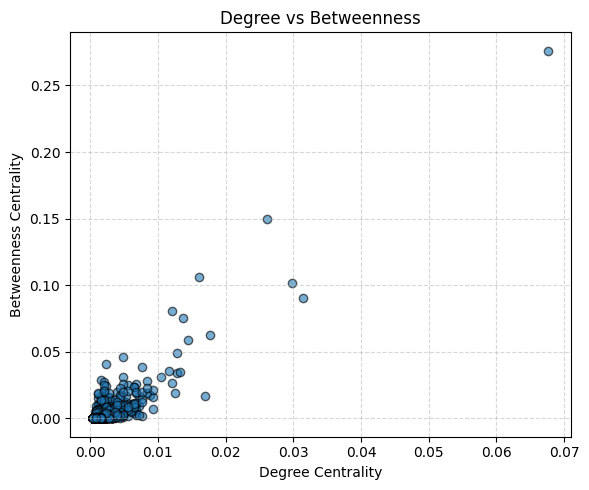


--- Matrice di correlazione tra le centralità (Pearson) ---
                  degree_cent  closeness_cent  betweenness_cent  \
degree_cent          1.000000        0.317843          0.876926   
closeness_cent       0.317843        1.000000          0.281158   
betweenness_cent     0.876926        0.281158          1.000000   
eigenvector_cent     0.513324        0.355138          0.494531   

                  eigenvector_cent  
degree_cent               0.513324  
closeness_cent            0.355138  
betweenness_cent          0.494531  
eigenvector_cent          1.000000  


In [19]:
# =================================================================
# 9. Centrality Measures
# =================================================================

# ------------------------------------------------------------
# 9.1 Calcolo delle centralità sul grafo indiretto (G_undir_lwc)
# ------------------------------------------------------------

# 1) Degree Centrality
deg_cent = nx.degree_centrality(G_undir_lwc)

# 2) Closeness Centrality
#    (attenzione: su grafi grandi può essere lento, ma con ~2485 nodi è fattibile)
close_cent = nx.closeness_centrality(G_undir_lwc)

# 3) Betweenness Centrality
#    (con normalized=True ottieni valori tra 0 e 1)
between_cent = nx.betweenness_centrality(G_undir_lwc, normalized=True)

# 4) Eigenvector Centrality
#    (usiamo l’algoritmo numpy per robustezza; max_iter e tol possono essere adattati)
eigen_cent = nx.eigenvector_centrality_numpy(G_undir_lwc)

# Facciamo un DataFrame per aggregare i risultati e ordinarli
centrality_df = pd.DataFrame({
    "node": list(deg_cent.keys()),
    "degree_cent": list(deg_cent.values()),
    "closeness_cent": [close_cent[n] for n in deg_cent.keys()],
    "betweenness_cent": [between_cent[n] for n in deg_cent.keys()],
    "eigenvector_cent": [eigen_cent[n] for n in deg_cent.keys()]
})

# Aggiungiamo anche la classe del paper, qualora serva per confronti
centrality_df["class"] = centrality_df["node"].map(lambda n: G_undir_lwc.nodes[n]["class"])

# Ordiniamo per ciascuna misura e stampiamo i primi 10
print("\n--- Top 10 degree centrality (undirected) ---")
print(centrality_df.sort_values("degree_cent", ascending=False)
                   .head(10)[["node", "class", "degree_cent"]])

print("\n--- Top 10 closeness centrality (undirected) ---")
print(centrality_df.sort_values("closeness_cent", ascending=False)
                   .head(10)[["node", "class", "closeness_cent"]])

print("\n--- Top 10 betweenness centrality (undirected) ---")
print(centrality_df.sort_values("betweenness_cent", ascending=False)
                   .head(10)[["node", "class", "betweenness_cent"]])

print("\n--- Top 10 eigenvector centrality (undirected) ---")
print(centrality_df.sort_values("eigenvector_cent", ascending=False)
                   .head(10)[["node", "class", "eigenvector_cent"]])

# ------------------------------------------------------------
# 9.2 PageRank sul grafo diretto (G_dir_lwc)
# ------------------------------------------------------------
# Se ti interessa la versione direzionale, calcoliamo anche il PageRank
pagerank_cent = nx.pagerank(G_dir_lwc, alpha=0.85)

pagerank_df = pd.DataFrame({
    "node": list(pagerank_cent.keys()),
    "pagerank": list(pagerank_cent.values())
})
pagerank_df["class"] = pagerank_df["node"].map(lambda n: G_dir_lwc.nodes[n]["class"])

print("\n--- Top 10 PageRank (directed) ---")
print(pagerank_df.sort_values("pagerank", ascending=False)
                   .head(10)[["node", "class", "pagerank"]])

# ------------------------------------------------------------
# 9.3 Distribuzione delle centralità (istogrammi)
# ------------------------------------------------------------
plt.figure(figsize=(12, 8))

# Istogramma della degree centrality
plt.subplot(2, 2, 1)
plt.hist(list(deg_cent.values()), bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Degree Centrality")
plt.ylabel("Conteggio")
plt.title("Distribuzione Degree Centrality")

# Istogramma della closeness centrality
plt.subplot(2, 2, 2)
plt.hist(list(close_cent.values()), bins=50, color='salmon', edgecolor='black')
plt.xlabel("Closeness Centrality")
plt.ylabel("Conteggio")
plt.title("Distribuzione Closeness Centrality")

# Istogramma della betweenness centrality
plt.subplot(2, 2, 3)
plt.hist(list(between_cent.values()), bins=50, color='lightgreen', edgecolor='black')
plt.xlabel("Betweenness Centrality")
plt.ylabel("Conteggio")
plt.title("Distribuzione Betweenness Centrality")

# Istogramma dell’eigenvector centrality
plt.subplot(2, 2, 4)
plt.hist(list(eigen_cent.values()), bins=50, color='plum', edgecolor='black')
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Conteggio")
plt.title("Distribuzione Eigenvector Centrality")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9.4 Correlazioni tra diverse misure di centralità
# ------------------------------------------------------------
# Facciamo un plot scatter per confrontare, ad esempio, degree vs. betweenness
plt.figure(figsize=(6, 5))
plt.scatter(centrality_df["degree_cent"], centrality_df["betweenness_cent"], alpha=0.6, edgecolor='k')
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Degree vs Betweenness")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Se vuoi, puoi calcolare il coefficiente di correlazione (es. Pearson) tra le misure
corr_matrix = centrality_df[["degree_cent", "closeness_cent", "betweenness_cent", "eigenvector_cent"]].corr()
print("\n--- Matrice di correlazione tra le centralità (Pearson) ---")
print(corr_matrix)


First 36 eigenvalues of L_norm:
[7.12225170e-09 4.78399524e-03 7.43476221e-03 8.62625502e-03
 1.75065455e-02 1.78078354e-02 1.96819059e-02 1.98990764e-02
 2.17149520e-02 2.28133872e-02 2.35567290e-02 2.59781217e-02
 3.29537882e-02 3.56419952e-02 3.64745915e-02 3.82860063e-02
 3.96952619e-02 4.23938498e-02 4.42842136e-02 4.54522377e-02
 4.62170747e-02 4.76558811e-02 4.81479048e-02 5.09101662e-02
 5.35760331e-02 5.56475719e-02 5.64899569e-02 5.77019552e-02
 5.97498124e-02 6.18518185e-02 6.56972129e-02 6.59057892e-02
 6.67863871e-02 6.75806894e-02 6.82740304e-02 7.04088885e-02]


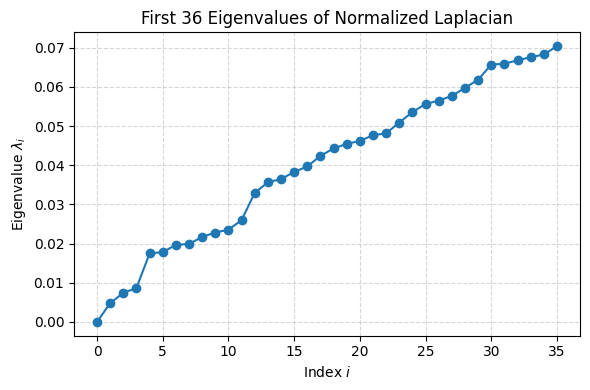

Suggested k (largest eigengap): 4

--- Community Sizes (k = 4) ---
Community 0: 2344 nodes
Community 1: 21 nodes
Community 2: 88 nodes
Community 3: 32 nodes

--- Ground-Truth Class Composition per Spectral Community ---
Community 0:
   Neural_Networks        700
   Genetic_Algorithms     406
   Theory                 344
   Case_Based             285
   Probabilistic_Methods  264
   Reinforcement_Learning 214
   Rule_Learning          131

Community 1:
   Neural_Networks         21

Community 2:
   Probabilistic_Methods   83
   Neural_Networks          5

Community 3:
   Probabilistic_Methods   32



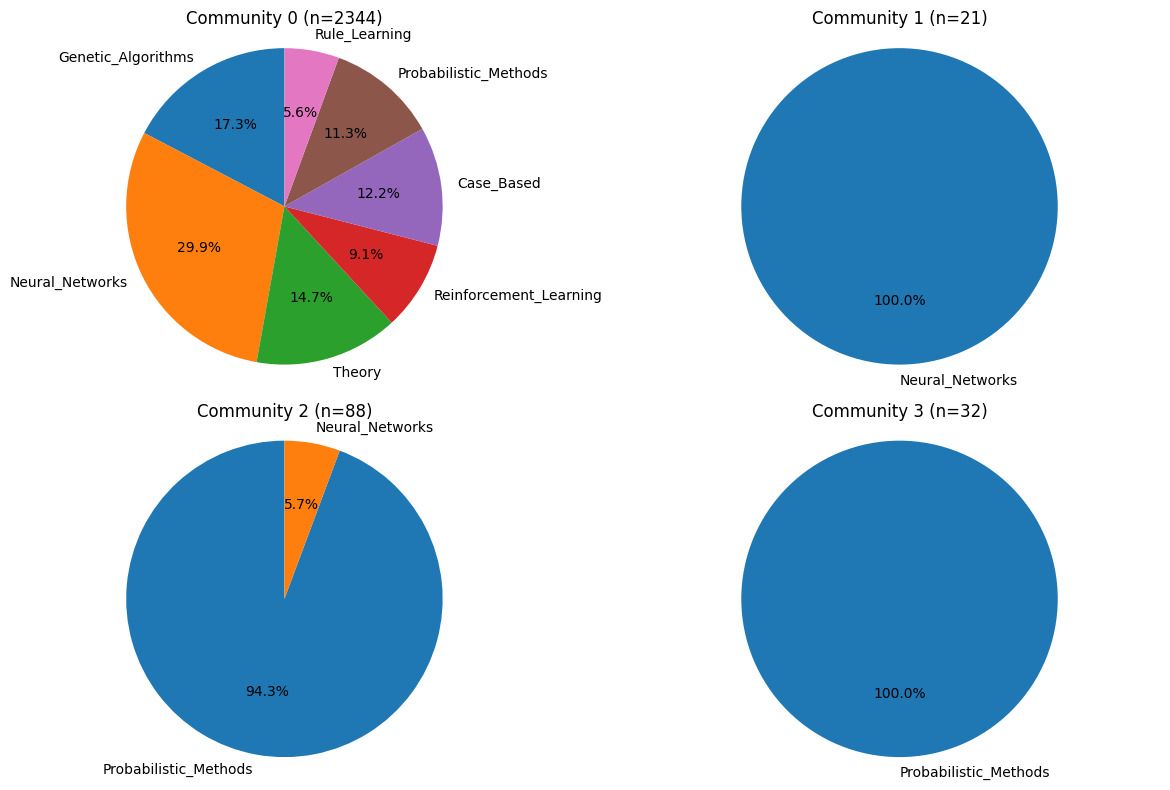

In [20]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import math

# -----------------------------------------------------------------
# 10.1 Build adjacency matrix A for G_undir_lwc (undirected)
# -----------------------------------------------------------------
nodes_list = list(G_undir_lwc.nodes())
n = len(nodes_list)
idx_map = { node: i for i, node in enumerate(nodes_list) }

rows = []
cols = []
for u, v in G_undir_lwc.edges():
    i = idx_map[u]
    j = idx_map[v]
    # Undirected: add both (i,j) and (j,i)
    rows.append(i)
    cols.append(j)
    rows.append(j)
    cols.append(i)

data = np.ones(len(rows), dtype=np.float32)
A = sp.csr_matrix((data, (rows, cols)), shape=(n, n))

# -----------------------------------------------------------------
# 10.2 Compute normalized Laplacian L_norm = I - D^{-1/2} A D^{-1/2}
# -----------------------------------------------------------------
deg = np.array(A.sum(axis=1)).flatten()  # degree of each node

with np.errstate(divide='ignore'):
    inv_sqrt_deg = 1.0 / np.sqrt(deg)
    inv_sqrt_deg[np.isinf(inv_sqrt_deg)] = 0.0

D_inv_sqrt = sp.diags(inv_sqrt_deg)
I = sp.eye(n, format='csr')
L_norm = I - (D_inv_sqrt @ A @ D_inv_sqrt)

# -----------------------------------------------------------------
# 10.3 Inspect first 36 eigenvalues to choose k
# -----------------------------------------------------------------
num_eigs = 36
eigvals, eigvecs = eigsh(L_norm, k=num_eigs, which='SM', tol=1e-4)

eigvals_sorted = np.sort(eigvals)
print("First %d eigenvalues of L_norm:" % num_eigs)
print(eigvals_sorted)

plt.figure(figsize=(6, 4))
plt.plot(range(num_eigs), eigvals_sorted, 'o-')
plt.xlabel(r"Index $i$")
plt.ylabel(r"Eigenvalue $\lambda_i$")
plt.title(r"First %d Eigenvalues of Normalized Laplacian" % num_eigs)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Based on the “eigengap” plot, choose k.
# (Here we fix k=4, but you can adjust or use the commented‐out automatic selection below.)
#k = 30


# Option B: pick k automatically by largest eigengap among the first num_eigs
gaps = eigvals_sorted[1:] - eigvals_sorted[:-1]   # λ_{i+1} - λ_i
k_estimated = np.argmax(gaps[:num_eigs-1]) + 1     # +1 because gaps[i] = λ_{i+1} - λ_i
print("Suggested k (largest eigengap):", k_estimated)
k = k_estimated

# -----------------------------------------------------------------
# 10.4 Recompute first (k+1) eigenvectors, then form X_spectral = [eigvecs2[:,1],...,eigvecs2[:,k]]
# -----------------------------------------------------------------
num_eigs2 = k + 1
eigvals2, eigvecs2 = eigsh(L_norm, k=num_eigs2, which='SM', tol=1e-4)
order = np.argsort(eigvals2)
eigvals2 = eigvals2[order]
eigvecs2 = eigvecs2[:, order]

# Drop the trivial first eigenvector (λ_0 ≈ 0), keep next k eigenvectors
X_spectral = eigvecs2[:, 1:(k+1)]  # shape = (n, k)

# -----------------------------------------------------------------
# 10.5 Run k‐means on rows of X_spectral
# -----------------------------------------------------------------
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_spectral)

# -----------------------------------------------------------------
# 10.6 Attach community labels back to G_undir_lwc
# -----------------------------------------------------------------
for node, idx in idx_map.items():
    G_undir_lwc.nodes[node]['spectral_comm'] = int(labels[idx])

# -----------------------------------------------------------------
# 10.7 Print community sizes
# -----------------------------------------------------------------
comm_counts = Counter(labels)
print("\n--- Community Sizes (k = %d) ---" % k)
for comm_id, size in sorted(comm_counts.items()):
    print(f"Community {comm_id}: {size} nodes")

# -----------------------------------------------------------------
# 10.8 Print ground‐truth class composition per community
# -----------------------------------------------------------------
print("\n--- Ground-Truth Class Composition per Spectral Community ---")
gt_table = defaultdict(list)
for node, idx in idx_map.items():
    comm = labels[idx]
    cls = G_undir_lwc.nodes[node]['class']
    gt_table[comm].append(cls)

for comm_id in sorted(gt_table.keys()):
    cls_list = gt_table[comm_id]
    freq = Counter(cls_list)
    print(f"Community {comm_id}:")
    for cls, cnt in freq.most_common():
        print(f"   {cls:<22} {cnt:>3}")
    print()



# -----------------------------------------------------------------
# 11. Pie‐Charts: Ground‐Truth Class Distribution in Each Community
# -----------------------------------------------------------------
comm_to_classes = defaultdict(list)
for node, data in G_undir_lwc.nodes(data=True):
    comm_id = data.get('spectral_comm', None)
    cls     = data.get('class', None)
    if (comm_id is not None) and (cls is not None):
        comm_to_classes[comm_id].append(cls)

community_ids = sorted(comm_to_classes.keys())
k = len(community_ids)

# Layout: 2 columns, compute needed rows
ncols = 2
nrows = math.ceil(k / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
axes = axes.flatten()

for idx, comm_id in enumerate(community_ids):
    class_list = comm_to_classes[comm_id]
    freq       = Counter(class_list)
    labels_pie = list(freq.keys())
    sizes      = list(freq.values())

    ax = axes[idx]
    ax.pie(
        sizes,
        labels=labels_pie,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    ax.axis('equal')
    ax.set_title(f"Community {comm_id} (n={len(class_list)})", fontsize=12)

# Hide any unused subplots
for j in range(k, nrows * ncols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
# =================================================================
# End of Spectral Community Detection + Pie‐Charts
# =================================================================

# Spectral analysis improved version

# Louvain


--- Louvain Community Detection with Resolution Tuning ---
Resolution 0.5: 126 communities | Modularity: 0.7592
Resolution 0.6: 24 communities | Modularity: 0.7994
Resolution 0.7: 26 communities | Modularity: 0.8022
Resolution 0.8: 31 communities | Modularity: 0.8043
Resolution 0.9: 28 communities | Modularity: 0.8029
Resolution 1.0: 27 communities | Modularity: 0.8053
Resolution 1.1: 30 communities | Modularity: 0.8034
Resolution 1.2000000000000002: 32 communities | Modularity: 0.8062
Resolution 1.3: 39 communities | Modularity: 0.8017
Resolution 1.4: 35 communities | Modularity: 0.8030
Resolution 1.5: 37 communities | Modularity: 0.8016
Resolution 1.6: 38 communities | Modularity: 0.7992
Resolution 1.7000000000000002: 41 communities | Modularity: 0.7987
Resolution 1.8: 42 communities | Modularity: 0.7956
Resolution 1.9000000000000001: 45 communities | Modularity: 0.7934
Resolution 2.0: 45 communities | Modularity: 0.7945

Selected resolution 1.2000000000000002 with modularity 0.8062

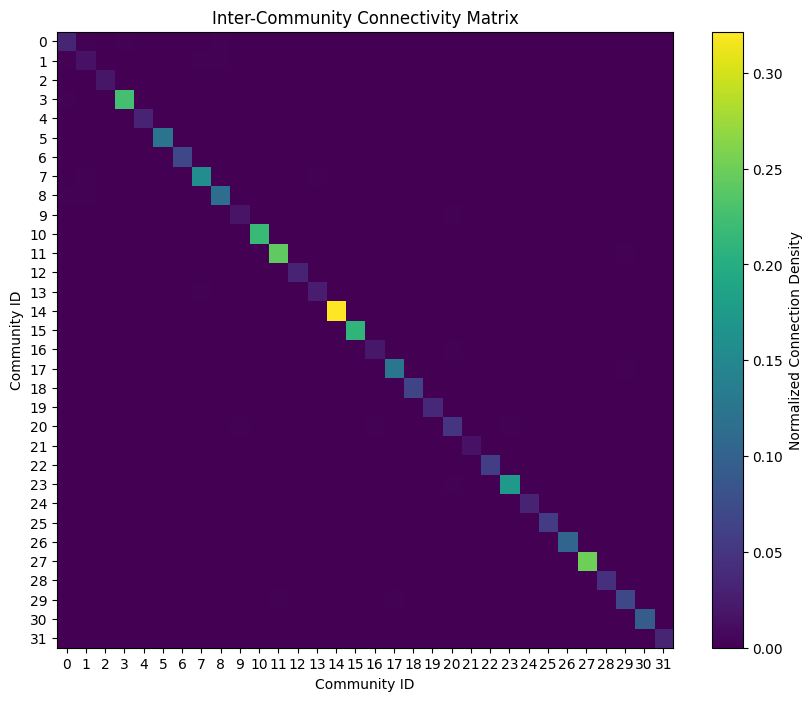


Community hubs (highest degree nodes):
Community 0: Node 45605 (deg=11, class=Genetic_Algorithms)
Community 1: Node 35 (deg=115, class=Genetic_Algorithms)
Community 2: Node 1365 (deg=54, class=Neural_Networks)
Community 3: Node 13658 (deg=7, class=Neural_Networks)
Community 4: Node 35922 (deg=12, class=Probabilistic_Methods)
Community 9: Node 3231 (deg=31, class=Theory)
Community 6: Node 87417 (deg=8, class=Genetic_Algorithms)
Community 7: Node 12576 (deg=16, class=Genetic_Algorithms)
Community 8: Node 54129 (deg=12, class=Genetic_Algorithms)
Community 25: Node 29492 (deg=6, class=Neural_Networks)
Community 12: Node 33818 (deg=8, class=Neural_Networks)
Community 13: Node 6213 (deg=72, class=Reinforcement_Learning)
Community 14: Node 102938 (deg=3, class=Neural_Networks)
Community 16: Node 2440 (deg=29, class=Rule_Learning)
Community 17: Node 65074 (deg=11, class=Probabilistic_Methods)
Community 18: Node 10186 (deg=6, class=Theory)
Community 19: Node 1959 (deg=10, class=Case_Based)
Com

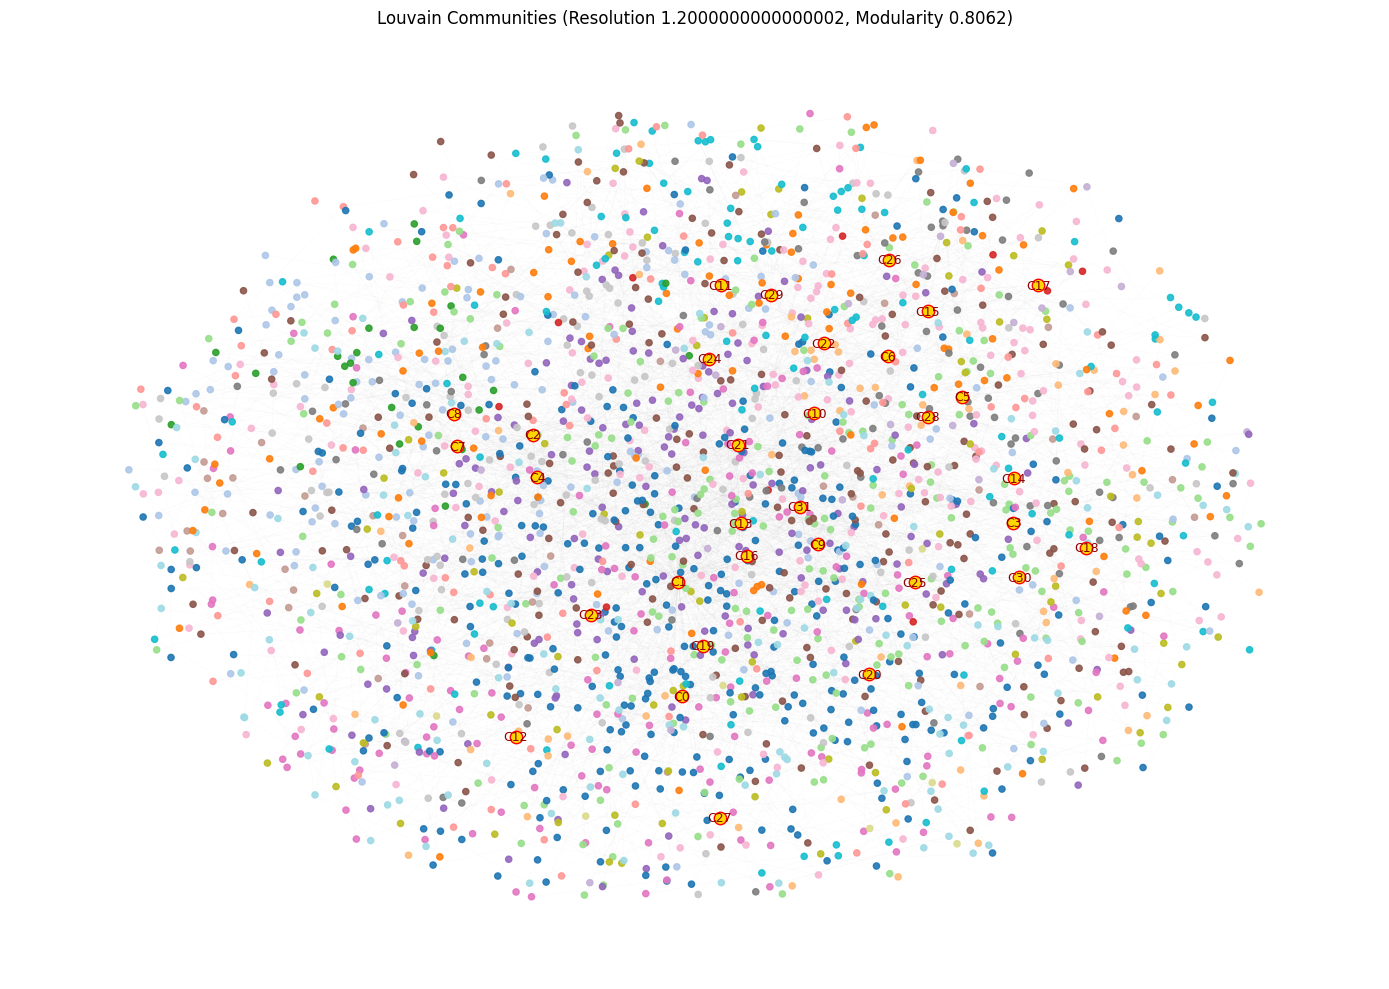


Adjusted Rand Index with Spectral Clustering: 0.0128

Community detection analysis complete!


In [23]:
# =================================================================
# 14. Community Detection: Louvain (Undirected) - Enhanced Analysis
# =================================================================

import networkx as nx
import community as community_louvain
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

# -----------------------------------------------------------------------------
# 14.1 Louvain with Resolution Tuning
# -----------------------------------------------------------------------------
print("\n--- Louvain Community Detection with Resolution Tuning ---")
resolutions = np.linspace(0.5,2.0,16) # Test different granularities
best_modularity = -1
best_partition = None
best_res = 1.0  # Default resolution

for res in resolutions:
    partition = community_louvain.best_partition(G_undir_lwc, resolution=res)
    mod = community_louvain.modularity(partition, G_undir_lwc)
    print(f"Resolution {res}: {len(set(partition.values()))} communities | Modularity: {mod:.4f}")
    
    if mod > best_modularity:
        best_modularity = mod
        best_partition = partition
        best_res = res

louvain_partition = best_partition
print(f"\nSelected resolution {best_res} with modularity {best_modularity:.4f}")

# Attach labels to graph
nx.set_node_attributes(G_undir_lwc, louvain_partition, 'louvain_comm')

# -----------------------------------------------------------------------------
# 14.2 Community Structure Analysis
# -----------------------------------------------------------------------------
# Get community memberships
louvain_comms = defaultdict(list)
for node, comm_id in louvain_partition.items():
    louvain_comms[comm_id].append(node)

print(f"\nNumber of communities: {len(louvain_comms)}")
print("Top 5 largest communities:")
for comm_id, nodes in sorted(louvain_comms.items(), key=lambda kv: -len(kv[1]))[:5]:
    print(f"  Community {comm_id}: {len(nodes)} nodes")

# -----------------------------------------------------------------------------
# 14.3 Semantic Alignment Analysis
# -----------------------------------------------------------------------------
# Get ground truth classes
true_labels = [data['class'] for _, data in G_undir_lwc.nodes(data=True)]
comm_labels = [louvain_partition[n] for n in G_undir_lwc.nodes]

# Calculate alignment metrics
nmi = normalized_mutual_info_score(true_labels, comm_labels)
print(f"\nNormalized Mutual Info with classes: {nmi:.4f}")

# Class distribution per community
print("\nCommunity class distributions:")
class_names = sorted(set(true_labels))
for comm_id, nodes in louvain_comms.items():
    if len(nodes) < 10: continue  # Skip small communities
    class_dist = Counter([G_undir_lwc.nodes[n]['class'] for n in nodes])
    total = len(nodes)
    
    dist_str = ", ".join([f"{cls}: {count/total:.1%}" 
                         for cls, count in class_dist.most_common(3)])
    print(f"Community {comm_id} ({len(nodes)} nodes): {dist_str}")

# Purity calculation
purities = []
for comm_id, nodes in louvain_comms.items():
    if len(nodes) == 0: continue
    class_counts = Counter([G_undir_lwc.nodes[n]['class'] for n in nodes])
    purity = max(class_counts.values()) / len(nodes)
    purities.append(purity)
    
print(f"\nAverage community purity: {np.mean(purities):.4f}")

# -----------------------------------------------------------------------------
# 14.4 Inter-Community Connectivity
# -----------------------------------------------------------------------------
# Create community connectivity matrix
comm_ids = sorted(set(louvain_partition.values()))
n_comms = len(comm_ids)
comm_matrix = np.zeros((n_comms, n_comms))

# Map community ID to matrix index
comm_index = {cid: idx for idx, cid in enumerate(comm_ids)}

# Count edges between communities
for u, v in G_undir_lwc.edges():
    comm_u = comm_index[louvain_partition[u]]
    comm_v = comm_index[louvain_partition[v]]
    comm_matrix[comm_u][comm_v] += 1
    if comm_u != comm_v:  # Avoid double-count for symmetric matrix
        comm_matrix[comm_v][comm_u] += 1

# Normalize by community size
for i in range(n_comms):
    size_i = len(louvain_comms[comm_ids[i]])
    for j in range(n_comms):
        size_j = len(louvain_comms[comm_ids[j]])
        
        if i == j:
            # Calculate maximum possible edges within community
            denom = size_i * (size_i - 1) / 2
            if denom > 0:
                comm_matrix[i][j] /= denom
            else:
                comm_matrix[i][j] = 0
        else:
            # Calculate maximum possible edges between communities
            denom = size_i * size_j
            if denom > 0:
                comm_matrix[i][j] /= denom
            else:
                comm_matrix[i][j] = 0

# Visualize
plt.figure(figsize=(10, 8))
plt.imshow(comm_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Normalized Connection Density')
plt.title("Inter-Community Connectivity Matrix")
plt.xlabel("Community ID")
plt.ylabel("Community ID")
plt.xticks(range(n_comms), comm_ids)
plt.yticks(range(n_comms), comm_ids)
plt.show()

# -----------------------------------------------------------------------------
# 14.5 Hub Identification
# -----------------------------------------------------------------------------
print("\nCommunity hubs (highest degree nodes):")
for comm_id, nodes in louvain_comms.items():
    if len(nodes) < 5: continue  # Skip small communities
    comm_subgraph = G_undir_lwc.subgraph(nodes)
    degrees = comm_subgraph.degree(nodes)
    hub_node, hub_degree = max(degrees, key=lambda x: x[1])
    hub_class = G_undir_lwc.nodes[hub_node]['class']
    print(f"Community {comm_id}: Node {hub_node} (deg={hub_degree}, class={hub_class})")

# -----------------------------------------------------------------------------
# 14.6 Visualization
# -----------------------------------------------------------------------------
print("\nGenerating community visualization...")
plt.figure(figsize=(14, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G_undir_lwc, seed=42, k=0.15)

# Draw nodes with community colors
cmap = plt.cm.tab20
node_colors = [louvain_partition[n] for n in G_undir_lwc.nodes()]
vmin = min(node_colors)
vmax = max(node_colors)

nx.draw_networkx_nodes(
    G_undir_lwc, pos, 
    node_size=20,
    node_color=node_colors,
    cmap=cmap,
    alpha=0.9,
    vmin=vmin,
    vmax=vmax
)

# Draw edges with low alpha to reduce clutter
nx.draw_networkx_edges(
    G_undir_lwc, pos,
    alpha=0.05,
    width=0.3,
    edge_color='gray'
)

# Highlight hub nodes
hubs = []
hub_comm = {}
for comm_id, nodes in louvain_comms.items():
    if len(nodes) >= 5:
        comm_subgraph = G_undir_lwc.subgraph(nodes)
        hub_node = max(comm_subgraph.degree, key=lambda x: x[1])[0]
        hubs.append(hub_node)
        hub_comm[hub_node] = comm_id
        
# Draw hubs with larger size and border
nx.draw_networkx_nodes(
    G_undir_lwc, pos,
    nodelist=hubs,
    node_size=80,
    node_color='gold',
    edgecolors='red',
    linewidths=1.0
)

# Label hub nodes with community ID
hub_labels = {node: f"C{hub_comm[node]}" for node in hubs}
nx.draw_networkx_labels(
    G_undir_lwc, pos,
    labels=hub_labels,
    font_size=9,
    font_color='darkred'
)

plt.title(f"Louvain Communities (Resolution {best_res}, Modularity {best_modularity:.4f})")
plt.axis('off')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 14.7 Comparison with Spectral Clustering
# -----------------------------------------------------------------------------
# Check if spectral_comm attribute exists
spectral_labels_available = any('spectral_comm' in data for _, data in G_undir_lwc.nodes(data=True))

if spectral_labels_available:
    spectral_labels = [data['spectral_comm'] for _, data in G_undir_lwc.nodes(data=True)]
    ari = adjusted_rand_score(comm_labels, spectral_labels)
    print(f"\nAdjusted Rand Index with Spectral Clustering: {ari:.4f}")
else:
    print("\nSpectral labels not found for comparison")

print("\nCommunity detection analysis complete!")

In [22]:
import pandas as pd
import networkx as nx
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from collections import Counter, defaultdict

def evaluate_partition(G, partition_key):
    """
    G             : networkx Graph
    partition_key : node attribute name (e.g. 'spectral_comm' or 'louvain_comm')
    Returns the tuple (n_comms, modularity, NMI, ARI, avg_purity).
    """
    # 1) Build dict and communities list
    partition = {n: data[partition_key] for n, data in G.nodes(data=True)}
    comm_to_nodes = defaultdict(list)
    for n, cid in partition.items():
        comm_to_nodes[cid].append(n)
    communities = list(comm_to_nodes.values())

    # 2) Ground-truth vs. predicted label arrays (in the same node order)
    nodes = list(G.nodes())
    true_labels = [G.nodes[n]['class'] for n in nodes]
    pred_labels = [partition[n]       for n in nodes]

    # 3) Metrics
    n_comms   = len(communities)
    Q         = nx_modularity(G, communities)
    nmi       = normalized_mutual_info_score(true_labels, pred_labels)
    ari       = adjusted_rand_score(true_labels, pred_labels)
    # purity
    purities  = []
    for members in communities:
        cnt = Counter(G.nodes[n]['class'] for n in members)
        purities.append(max(cnt.values()) / len(members))
    avg_purity = sum(purities) / len(purities)

    return n_comms, Q, nmi, ari, avg_purity

# --- Evaluate both partitions ---
metrics = []
for key, name in [('spectral_comm', 'Spectral'),
                  ('louvain_comm', 'Louvain')]:
    n_comms, Q, nmi, ari, purity = evaluate_partition(G_undir_lwc, key)
    metrics.append({
        'Method':       name,
        '# Comms':      n_comms,
        'Modularity':   round(Q,    4),
        'NMI':          round(nmi,   4),
        'ARI':          round(ari,   4),
        'Avg. Purity':  round(purity,4)
    })

# 3) Build a DataFrame for easy viewing
df = pd.DataFrame(metrics)
print(df.to_string(index=False))


  Method  # Comms  Modularity    NMI    ARI  Avg. Purity
Spectral        4      0.0882 0.0939 0.0071       0.8105
 Louvain       28      0.8075 0.4647 0.2948       0.7942
